In [1]:
import os
import time
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_extraction import image
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from skimage.feature import hog, daisy, local_binary_pattern
from skimage import io
from skimage.transform import rotate, resize
from skimage.util import random_noise
from scipy import ndimage

# Practica 1

Prats Guasch, Víctor Antonio

## 1. Problema a resoldre

En aquesta pràctica es planteja la creació d'un classificador d'imatges mitjançant les màquines de suport de vectors o SVM, segons les seves sigles en anglès. Es presenten dos possibles conjunts de dades, s'ha escollit el que presenta 15 categories de diferents tipus de paisatges. Per a dur a terme la tasca proposada, serà necessari seguir les següents pautes:

* Anàlisi del conjunt de dades donat
* Extracció de característiques significatives
* Entrenament del model
* Cerca dels paràmetres òptims del model
* Avaluació del rendiment del model dalt un conjunt de dades desconegut

Tal com s'indica, en primer lloc, és necessari analitzar el conjunt de dades proporcionat de manera que es determini quin format tenen les imatges, quines són les possibles característiques a extreure o si s'ha d'aplicar algun tipus de neteja.

## 2. Anàlisi del conjunt de dades

El conjunt de dades donat està format per dos directoris, que contenen les dades de entrenament i de test respectivament. Cada directori conté 15 directoris amb les imatges de la seva respectiva categoria. Per explorar les dades, construïm una funció que recorrerà el directori pare i guardarà a el nom de cada carpeta con a l'indentificador de la seva categoria.

In [2]:
def get_image_files_by_folder(root_folder, image_extensions=('jpg', 'jpeg', 'png', 'gif', 'bmp')):
    image_files_by_folder = {}

    # Walk through the root folder and its subdirectories
    for folder_path, _, files in os.walk(root_folder):
        folder_name = os.path.basename(folder_path)
        image_files = []

        for file in files:
            file_extension = file.lower().split('.')[-1]
            if file_extension in image_extensions:
                image_files.append(os.path.join(folder_path, file))

        if image_files:
            image_files_by_folder[folder_name] = image_files

    return image_files_by_folder

In [3]:
get_image_files_by_folder('data/train').keys()

dict_keys(['bedroom', 'Coast', 'Forest', 'Highway', 'industrial', 'Insidecity', 'kitchen', 'livingroom', 'Mountain', 'Office', 'OpenCountry', 'store', 'Street', 'Suburb', 'TallBuilding'])

In [4]:
get_image_files_by_folder('data/test').keys()

dict_keys(['bedroom', 'coast', 'forest', 'highway', 'industrial', 'insidecity', 'kitchen', 'livingRoom', 'livingRoom (Case Conflict)', 'mountain', 'office', 'opencountry', 'store', 'street', 'suburb', 'tallbuilding'])

Observant els noms de les categories (o directoris) podem veure dos petits problemes amb el conjunt de dades donat:

* **Les categories no tenen la mateixa nomenclatura**, algunes són presentades en CamelCase mentre que altres (com és el cas del conjunt de test) estan completament en minúscula

Aquest problema es pot solucionar de manera senzilla, ja sigui canviant de nom els directoris originals o transformant les categories al mateix format, mitjançant la funció .lower()

* **El conjunt de test conté una categoria "addicional"** que no està present al conjunt d'entrenament

Aquesta categoria és anomenada "livingRoom (Case Conflict)". Les imatges contingudes són de la categoria 'livingRoom' tot i que contenen elements que poden dificultar el reconeixement per al model. Per a la primera aproximació aquesta categoria serà exclosa i una vegada entrenat el model es podrà analitzar quin rendiment té la seva generalització en escenaris més diversos.

Si s'analitzen les imatges d'alguna de les categories, com és per exemple "bedroom", es pot veure que tot i que la majoria són en blanc i negre algunes contenen canals de color en sRGB. A més, veiem que la mida de les imatges no és constant sinó que oscil·la entre 200x200px i 300x300px.

Per a resoldre aquestes dues casuístiques, s'ha decidit que **totes les imatges es processaran en blanc i negre**, ignorant el color en cas que estigui present. A més, **es reescalaran a 200x200px** per assegurar una mida consistent.

A partir d'aquestes suposicions, construïm el primer dataframe amb totes les dades. Es llegirà tant el conjunt d'entrenament com el test, tot i que aquest darrer no es farà servir fins al darrer punt on es comprovi el rendiment final.

In [30]:
def get_image_files_by_folder(root_folder, categories_to_exclude = ['livingroom (case conflict)'],
                              image_extensions=('jpg', 'jpeg', 'png', 'gif', 'bmp')):
    image_files_by_folder = {}

    for folder_path, _, files in os.walk(root_folder):
        # Aseguram que les categories tinguin el mateix nom
        folder_name = os.path.basename(folder_path).lower()
        image_files = []

        if folder_name in categories_to_exclude:
            continue
        
        for file in files:
            file_extension = file.lower().split('.')[-1]
            if file_extension in image_extensions:
                image_files.append(os.path.join(folder_path, file))

        if image_files:
            image_files_by_folder[folder_name] = image_files

    return image_files_by_folder

def read_and_flatten_images(image_list, augment_data):
    image_data = []
    
    for image_path in image_list:
        img = io.imread(image_path, as_gray=True)
        img = resize(img, (200, 200))
        images = [img]
        if augment_data:
            flipped_img = img[:, ::-1]
            rotated_5 = rotate(img, 5)
            rotated_neg_5 = rotate(img, -5)
            rotated_10 = rotate(img, 10)
            rotated_neg_10 = rotate(img, -10)
            images = [img, flipped_img, rotated_5, rotated_neg_5, rotated_10, rotated_neg_10]
            
        for image_to_process in images:
            image_data.append(image_to_process.flatten())
    
    return image_data

def create_dataframe_from_categories(images_to_load, renames = {}, augment_data=False):
    df = pd.DataFrame()
    for label, image_list in images_to_load.items():
        image_data = read_and_flatten_images(images_to_load[label], augment_data)
        next_part = pd.DataFrame(image_data)
        if label in renames:
            next_part['label'] = renames[label]
        else:
            next_part['label'] = label
        df = pd.concat([df, next_part], ignore_index=True)
    return df

In [5]:
images_to_load_train = get_image_files_by_folder('data/train')
images_to_load_test = get_image_files_by_folder('data/test')

test_df = create_dataframe_from_categories(images_to_load_test)
train_df = create_dataframe_from_categories(images_to_load_train)

train_df_no_label = train_df.drop('label', axis=1)
train_labels = train_df['label']

Ja que els dataframes creats ja contenen el nom de les diferents categories esperades, podem verificar que el conjunt de dades d'entrenament estigui balancejat i que els noms de les categories siguin equivalents entre test i entrenament.

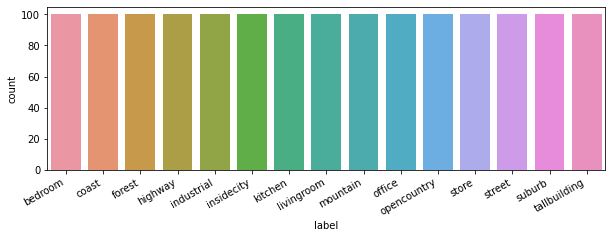

In [6]:
plt.figure(figsize=(10, 3))
ax = sns.countplot(x=train_df['label'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

In [7]:
(np.unique(train_df['label']) == np.unique(test_df['label'])).all()

True

Com podem veure, tenim exactament 100 exemples per a cada categoria i podem dir que el conjunt de dades d'entrenament està balancejat. Les categories són també equivalents entre els dos conjunts, per la qual cosa es pot procedir a l'extracció de característiques i entrenament del model.

## 3. Extracció de característiques - Experiments realitats

Per al disseny del model s'ha realitzat els següents experiments:

1. Rendiment del model sense extreure cap característica
2. Histogram of Oriented Gradients (HOG)
3. Augmentació de les dades d'entrenament i HOG
4. Augmentació de les dades d'entrenament i DAISY
5. Augmentació de les dades d'entrenament, HOG i Local Binary Pattern (LBP)

Per a mesurar el rendiment dels diferents models dins de cada categoria, crearem un gràfic basat en el `classification_report` mitjançant la següent [funció d'utilitat](https://stackoverflow.com/a/58948133):

In [25]:
def plot_classification_report(y_real, y_predicted):
    report = classification_report(y_real, y_predicted, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Greens')

### 3.1 Rendiment base del model

Aquest experiment busca determinar la línia base de rendiment del model. S'emprarà un model lineal sobre els píxels en blanc i negre aplanats de la imatge. El rendiment d'aquest experiment ha de ser superat per la resta de característiques extretes.

In [9]:
def fit_predict_svm(X_train, X_test, y_train, y_test):
    svm = SVC(kernel='linear', random_state=1)
    svm.fit(X_train, y_train)
    y_predicted = svm.predict(X_test)
    print(f"La precisició es de: {accuracy_score(y_test, y_predicted)}")
    
    return y_predicted

La precisició es de: 0.21333333333333335


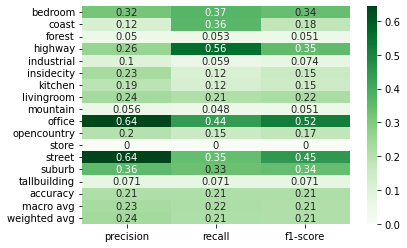

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(train_df_no_label, train_labels, test_size=0.20, random_state=1)
predicted = fit_predict_svm(X_train, X_validation, y_train, y_validation)
plot_classification_report(y_validation, predicted)

Cal destacar que aquest model tindrà resultats molt diferents depenent del nombre utilitzat per inicialitzar el generador de nombres aleatoris a l'hora de particionar les dades, per exemple, amb un `random_state=33` veurem un 28% de precisió en lloc del 21% observat. A més, podem veure que no es capaç de distingir categories com "forest", "store", "tallbuilding" o "industrial"

### 3.2 Histogram of oriented gradients (HOG)

Aquest mètode computa els canvis d'orientació de la imatge, de manera que accentua contorns i altres característiques rellevants. Els paràmetres òptims trobats pel HOG pel que fa a la dimensionalitat resultant i temps d'execució són els usats a les següents operacions, s'ha prioritzat un millor temps d'execució per poder realitzar una cerca de hiper paràmetres més exhaustiva a l'SVM. Aquest procés es troba descrit en més detall al notebook `Experiment2 - HOG.ipynb` adjunt.

La precisició es de: 0.64


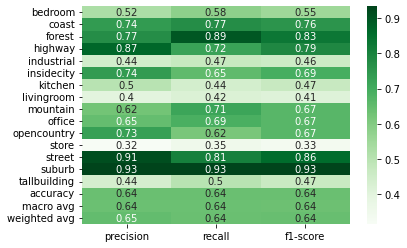

In [11]:
def apply_hog(row):
    image = row.values.reshape(200, 200)
    return hog(image, orientations=9, pixels_per_cell=(20, 20), 
               cells_per_block=(10, 10), channel_axis=None, transform_sqrt=True)

hog_df = train_df_no_label.apply(apply_hog, axis=1, result_type='expand')

X_train, X_validation, y_train, y_validation = train_test_split(hog_df, train_labels, test_size=0.20, random_state=1)
predicted = fit_predict_svm(X_train, X_validation, y_train, y_validation)
plot_classification_report(y_validation, predicted)

Com podem veure, aquest mètode genera millors resultats i arribam a veure una precisió superior al 50% sobre el conjunt de validació. Tot i que encara categories com "store", "tallbuilding" o "industrial" tenen una precisió menor a la resta, podem veure també l'efecte contrari, on "forest" és una de les millors categories en termes de precisió.

### 3.3 Augmentació de les dades d'entrenament i HOG

HOG genera bons resultats, però actualment es veu molt limitat pel nombre d'exemples presents en el conjunt de dades d'entrenament, com a referència, el conjunt de test és quasi 2 vegades més gran que el d'entrenament. Per a solucionar aquest problema podem aplicar diferents transformacions a les imatges originals, les aplicades són les següents:

* Gir horitzontal
* Rotació de 5 i -5 graus
* Rotació de 10 i -10 graus

Amb les transformacions enumerades afegim 5 noves imatges per cada imatge original, el que resulta en 9000 exemples en el conjunt d'entrenament.
S'ha considerat l'aplicació d'altres tècniques, com és un gir vertical (que no té sentit pel nostre conjunt de dades, ja que no trobarem imatges girades vertical d'edifici), l'aplicació d'un difuminat o l'addició de renou aleatori. Aquestes dues darreres tècniques reduïen la precisió del model.

In [12]:
# Recarregam les dades, aplicant les transformacions enumerades
train_df = create_dataframe_from_categories(images_to_load_train, augment_data=True)

train_df_no_label = train_df.drop('label', axis=1)
train_labels = train_df['label']

La precisició es de: 0.7427777777777778


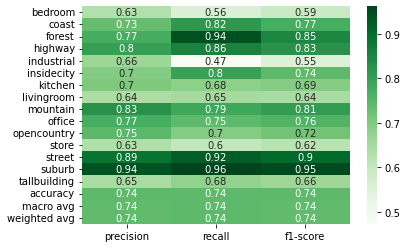

In [13]:
hog_df = train_df_no_label.apply(apply_hog, axis=1, result_type='expand')

X_train, X_validation, y_train, y_validation = train_test_split(hog_df, train_labels, test_size=0.20, random_state=1)
predicted = fit_predict_svm(X_train, X_validation, y_train, y_validation)
plot_classification_report(y_validation, predicted)

A partir dels nous exemples **la precisió ha augmentat un 12%**. Cal destacar que encara es fa servir un kernel lineal, que no és idoni per aquest dataset. L'objectiu és millorar tot el possible les features abans de provar quin serà el millor kernel i els seus respectius paràmetres. Les categories "tallbuilding" i "industrial" encara tenen precisions baixes, principalment ja que molts exemples són similars entre ells, cosa que s'explorarà posteriorment.

### 3.4 Augmentació de les dades d'entrenament i DAISY

Pareix que el HOG ha arribat a molt bons resultats per no haver configurat el kernel de l'SVM. Per tant, anam a explorar altres metodologies d'extracció de característiques per determinar si podem obtenir millors resultats. DAISY és un altre mètode basat en histogrames dels gradients d'orientació, comprovem el seu rendiment aprofitant les dades augmentades:

(9000, 9728)
La precisició es de: 0.8772222222222222


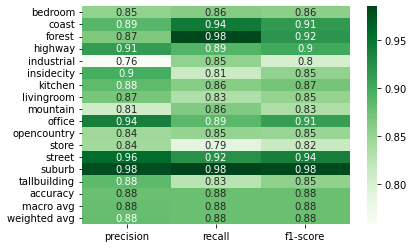

In [14]:
def apply_daisy(row):
    image = row.values.reshape(200, 200)
    descs=daisy(image, step=20, radius=20, rings=3, histograms=6,
                orientations=8, normalization='daisy')
    if descs.shape[0] != 3:
        descs=descs.transpose(1, 0, 2)
        
    return descs.reshape(descs.size).tolist()

daisy_df = train_df_no_label.apply(apply_daisy, axis=1, result_type='expand')
print(daisy_df.shape)

X_train, X_validation, y_train, y_validation = train_test_split(daisy_df, train_labels, test_size=0.20, random_state=1)
predicted = fit_predict_svm(X_train, X_validation, y_train, y_validation)
plot_classification_report(y_validation, predicted)

DAISY té un rendiment superior a HOG, però resta verificar que generalitzi de millor manera. Els contorns i les orientacions de la imatge pareixen no ser suficients per diferenciar totes les categories, d'aquesta idea neix el darrer experiment dut a terme.

### 3.5 Augmentació de les dades d'entrenament, HOG i Local Binary Pattern (LBP)

LBP és un mètode que analitza els punts a un cert radi d'un punt donat i comprova si aquests punts són majors o menors que el punt central. Un dels usos d'aquesta metodologia és la classificació de textures, el qual pot donar la informació requerida al model juntament amb els contorns trobats pel HOG. Per a la seva aplicació, se seguirà l'exemple que apareix a la [documentació](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-download-auto-examples-features-detection-plot-local-binary-pattern-py).

(9000, 20900)
La precisició es de: 0.11166666666666666


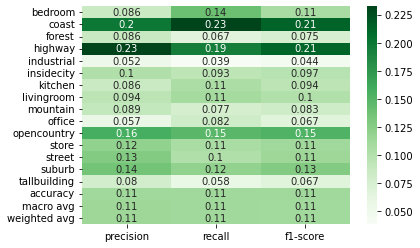

In [15]:
def apply_hog_lbp(row):
    radius = 3
    n_points = 8 * radius
    
    image = row.values.reshape(200, 200)
    lbp = local_binary_pattern(image, n_points, radius)
    pca = PCA(100)
    lbp_pca = pca.fit_transform(lbp).ravel()
    hog_vectors = hog(image, orientations=9, pixels_per_cell=(20, 20), 
                      cells_per_block=(10, 10), channel_axis=None, transform_sqrt=True)
    # ravel = flatten pero intenta evitar crear copies de l'array (modifica l'original)
    return np.concatenate((hog_vectors, lbp_pca))

hog_lbp_df = train_df_no_label.apply(apply_hog_lbp, axis=1, result_type='expand')
print(hog_lbp_df.shape)

X_train, X_validation, y_train, y_validation = train_test_split(hog_lbp_df, train_labels, test_size=0.20, random_state=1)
predicted = fit_predict_svm(X_train, X_validation, y_train, y_validation)
plot_classification_report(y_validation, predicted)

La inclusió de LBP causa que el model perdi completament la precisió, les dades de les textures generen renou sobre les 900 característiques del HOG i no és possible classificar aquest conjunt de dades només amb aquesta informació. Aquest model es veurà descartat.

Determinades les posibles característiques, es pot passar a la cerca del paràmetres òptims dels models donats.

## 4. Cerca dels paràmetres òptims del model

Per a trobar els hiperparàmetres òptims del model s'ha optat per fer servir una variació del mètode `GridSearchCV`, `HalvingGridSearchCV`. Aquest mètode busca reduir els candidats a avaluar en un ràtio de `factor` cada iteració (de manera similar a un torneig en esports). A més, les primeres iteracions reben menys recursos i aquests van augmentant a mesura que passen les iteracions. D'aquesta manera s'aconsegueixen uns resultats molt similars a la cerca exhaustiva en un temps menor.

### 4.1 Millors paràmetres per al conjunt de dades amb HOG

In [23]:
# Cream el dataframe de test
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

def apply_hog(row):
    image = row.values.reshape(200, 200)
    return hog(image, orientations=9, pixels_per_cell=(20, 20), 
               cells_per_block=(10, 10), channel_axis=None, transform_sqrt=True)

test_hog_df = X_test.apply(apply_hog, axis=1, result_type='expand')

In [27]:
def showResults(grid_result, number_to_show = 5):
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    results = sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True)
    for mean, stdev, param in itertools.islice(results, number_to_show):
        print(f"{mean} ({stdev}) with: {param}")
        
def find_rbf_kernel_params(X, y):
    C_range = np.logspace(-2, 4, 7)
    gamma_range = np.logspace(-4, 2, 7)
    param_grid = dict(gamma=gamma_range, C=C_range)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    grid_search = HalvingGridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, n_jobs=12, cv=cv, 
                                      scoring='accuracy',error_score=0, factor=3, verbose=10, aggressive_elimination=True)
    grid_result = grid_search.fit(X, y)

    showResults(grid_result)
    
    return grid_result.best_estimator_

def find_poly_kernel_params(X, y):
    param_grid = {
        'degree': [1, 2, 3, 4, 5, 6],
        'coef0': [0.1, 1, 10],
        'C': [0.01, 0.1, 1, 100, 10000],
        'gamma': [0.1, 1, 10]
    }

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    grid_search = HalvingGridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid, n_jobs=12, cv=cv, 
                                      scoring='accuracy',error_score=0, factor=3, verbose=10, aggressive_elimination=True)
    grid_result = grid_search.fit(X, y)

    showResults(grid_result)
    
    return grid_result.best_estimator_

In [17]:
best_rbf_hog = find_rbf_kernel_params(hog_df, train_labels)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 900
max_resources_: 9000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 900
Fitting 30 folds for each of 64 candidates, totalling 1920 fits
----------
iter: 1
n_candidates: 22
n_resources: 2700
Fitting 30 folds for each of 22 candidates, totalling 660 fits
----------
iter: 2
n_candidates: 8
n_resources: 8100
Fitting 30 folds for each of 8 candidates, totalling 240 fits
Best: 0.9184362139917696 using {'C': 100.0, 'gamma': 1.0}
0.9184362139917696 (0.009824623477412734) with: {'C': 100.0, 'gamma': 1.0}
0.9184362139917696 (0.009824623477412734) with: {'C': 10000.0, 'gamma': 1.0}
0.9184362139917696 (0.009824623477412734) with: {'C': 100000.0, 'gamma': 1.0}
0.9184362139917696 (0.009824623477412734) with: {'C': 1000.0, 'gamma': 1.0}
0.9173251028806585 (0.00964482990119197) with: {'C': 10.0, 'gamma': 1.0}


La precisició a dades desconegudes es de: 0.6814070351758794


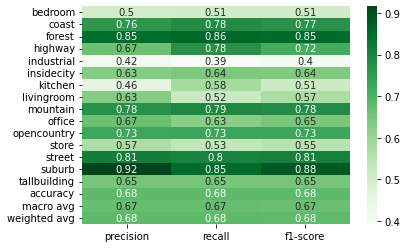

In [26]:
predicted = best_rbf_hog.predict(test_hog_df)

print(f"La precisició a dades desconegudes es de: {accuracy_score(y_test, predicted)}")
plot_classification_report(y_test, predicted)

In [28]:
best_poly_hog = find_poly_kernel_params(hog_df, train_labels)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 3
min_resources_: 900
max_resources_: 9000
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 270
n_resources: 900
Fitting 30 folds for each of 270 candidates, totalling 8100 fits
----------
iter: 1
n_candidates: 90
n_resources: 900
Fitting 30 folds for each of 90 candidates, totalling 2700 fits
----------
iter: 2
n_candidates: 30
n_resources: 900
Fitting 30 folds for each of 30 candidates, totalling 900 fits
----------
iter: 3
n_candidates: 10
n_resources: 900
Fitting 30 folds for each of 10 candidates, totalling 300 fits
----------
iter: 4
n_candidates: 4
n_resources: 2700
Fitting 30 folds for each of 4 candidates, totalling 120 fits
----------
iter: 5
n_candidates: 2
n_resources: 8100
Fitting 30 folds for each of 2 candidates, totalling 60 fits
Best: 0.9133744855967076 using {'C': 0.1, 'coef0': 10, 'degree': 3, 'gamma': 10}
0.9133744855967076 (0.009315785392241545) with: {'C': 0.1, 'coef0': 10, 'deg

La precisició a dades desconegudes es de: 0.6700167504187605


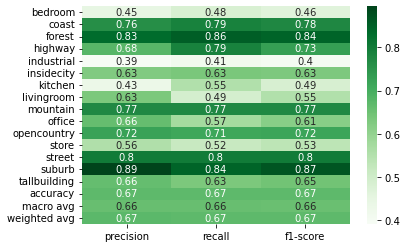

In [31]:
predicted = best_poly_hog.predict(test_hog_df)

print(f"La precisició a dades desconegudes es de: {accuracy_score(y_test, predicted)}")
plot_classification_report(y_test, predicted)

## 5. Conclusions

Aplicant el mètode holdout, hem pogut generar un model capaç de predir més del 90% dels casos de validació i un 68% dels casos de test, el que implica una bona capacitat de generalització. Cal tenir en compte que les dades test no contenen les imatges marcades com a 'case conflict' pel qual la precisió final serà un poc menor, comprovarem aquesta casuística amb el millor model:

La precisició a dades desconegudes es de: 0.6750557502389296


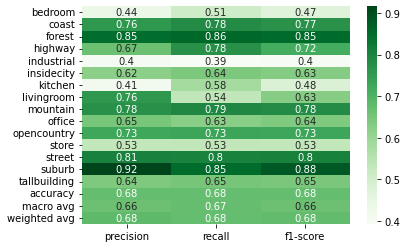

In [34]:
images_to_load_test = get_image_files_by_folder('data/test', categories_to_exclude=[])
test_df = create_dataframe_from_categories(images_to_load_test, renames={'livingroom (case conflict)': 'livingroom'})

# Cream el dataframe de test
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

def apply_hog(row):
    image = row.values.reshape(200, 200)
    return hog(image, orientations=9, pixels_per_cell=(20, 20), 
               cells_per_block=(10, 10), channel_axis=None, transform_sqrt=True)

test_hog_df = X_test.apply(apply_hog, axis=1, result_type='expand')

y_predicted = best_rbf_hog.predict(test_hog_df)

print(f"La precisició a dades desconegudes es de: {accuracy_score(y_test, y_predicted)}")
plot_classification_report(y_test, y_predicted)

### 5.1 Quines categories tenen major error?

Apart d'observar el report de precisió per categoria, podem contruir una gràfica que mostri totes les parelles de categories que divergeixen entre el conjunt de dades de test i les dades resultants de la predicció:

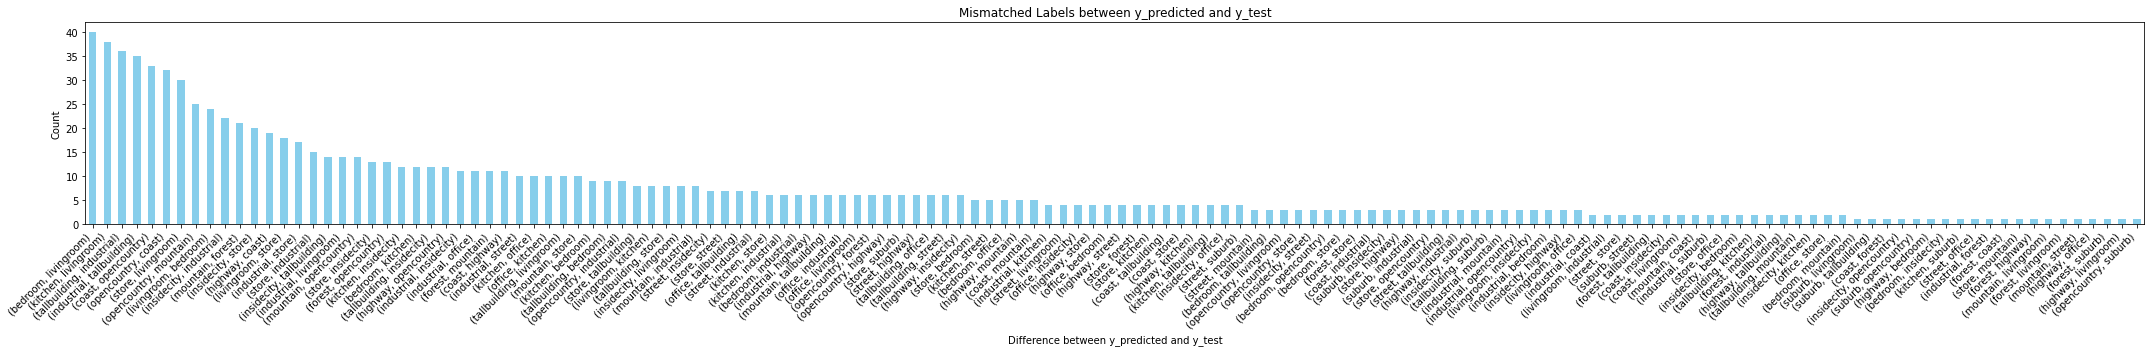

In [35]:
predicted_vs_expected = pd.Series(y_predicted).compare(pd.Series(y_test))
diff_counts = predicted_vs_expected.value_counts()

plt.figure(figsize=(30, 5))
ax = diff_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Difference between y_predicted and y_test')
plt.ylabel('Count')
plt.title('Mismatched Labels between y_predicted and y_test')
# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Incloure les imatges que causen conflictes han causat una caiguda d'un 0,5% de precisió a les dades de test, el que demostra que el model té bona capacitat de generalització. Com podem veure al gràfic superior, la categoria "bedroom" ha passat a tenir el nombre més gros de discrepàncies, juntament amb les categories que causaven problemes anteriorment, com eren "tallbuilding" i "industrial" o "coast" i "opencountry" que tenen exemples molt similars.